# Knowledge Distillation - Response-based Knowledge

![](RBKD2.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time

## 데이터 준비

In [2]:
mnist_transform = transforms.Compose([
    transforms.Resize(size = (28*28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(1.0,))
])

In [3]:
train_data = datasets.FashionMNIST('./data', train=True, download=True,transform=transforms.ToTensor())
valid_data = datasets.FashionMNIST('./data', train=False, download=True,transform=transforms.ToTensor())
test_data = datasets.FashionMNIST('./data', train=False, download=True,transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:00<00:00, 116761645.70it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 6130887.61it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 63049467.35it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21420909.71it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size= 64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset = valid_data, batch_size= 64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size= 64, shuffle=True)

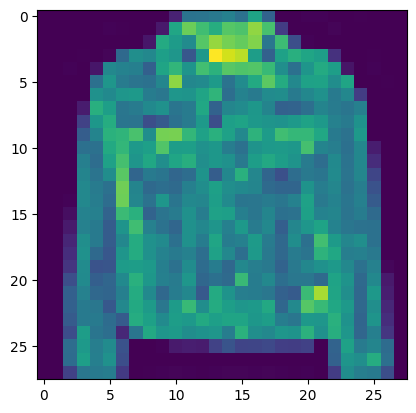

In [5]:
for batch_idx, (x, target) in enumerate(train_loader):
    plt.imshow(x[0,0])
    # print(x.reshape(-1,28*28)[0], target[0])
    break

## 네트워크 준비

In [6]:
class teacher_model(nn.Module):
    def __init__(self):
        super(teacher_model, self).__init__()
        self.layer1 = nn.Linear(784,512)
        self.layer2 = nn.Linear(512,256)
        self.layer3 = nn.Linear(256,128)
        self.layer4 = nn.Linear(128,64)
        self.layer5 = nn.Linear(64,32)
        self.layer6 = nn.Linear(32,10)

    def forward(self, x):
        x = x.view(-1,28*28)
        output = F.relu(self.layer1(x))
        output = F.relu(self.layer2(output))
        output = F.relu(self.layer3(output))
        output = F.relu(self.layer4(output))
        output = F.relu(self.layer5(output))
        output = self.layer6(output)
        return output

In [7]:
class student_model(nn.Module):
    def __init__(self):
        super(student_model, self).__init__()
        self.layer = nn.Linear(784,10)

    def forward(self, x):
        x = x.view(-1,28*28)
        output = self.layer(x)
        return output

## 네트워크 학습

In [ ]:
def T_train(T_model, train_loader, valid_loader, epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    T_model = T_model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizr = optim.Adam(T_model.parameters(), lr=0.001)

    T_train_loss = []
    T_val_loss = []

    for epch in tqdm(range(epochs+1)):
        #t_epoch_start = time.time()
        epch_loss = 0.0
        val_epch_loss = 0.0

        # 모델 학습
        T_model.train()
        for batch_idx, (x, target) in enumerate(train_loader):
            x, target = x.to(device), target.to(device)
            target = F.one_hot(target.to(torch.int64), num_classes = 10)

            yhat = T_model(x)

            loss = loss_fn(yhat.float(), target.float())

            optimizr.zero_grad()

            loss.requires_grad_(True)
            loss.backward()

            optimizr.step()

            epch_loss += loss.item()

        # 모델 검증
        T_model.eval()
        with torch.no_grad():
            for batch_idx, (x,y) in enumerate(valid_loader):
                x, y = x.to(device), y.to(device)
                y = F.one_hot(y.to(torch.int64), num_classes = 10)
                val_epch_loss += loss_fn(T_model(x).float(), y.float()).item()

        #t_epoch_finish = time.time()
        T_train_loss.append(epch_loss / batch_size)
        T_val_loss.append(val_epch_loss / batch_size)
        # if epch % 10 == 0:
        #     print('Epoch: {}, Loss: {}, Epoch_time: {:.4f}'
        #     .format(epch, epch_loss, t_epoch_finish - t_epoch_start))

    return T_train_loss, T_val_loss

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
T_model = teacher_model()

T_tr_loss, T_vl_loss = T_train(T_model, train_loader,valid_loader, epochs = 50)

  0%|          | 0/51 [00:00<?, ?it/s]

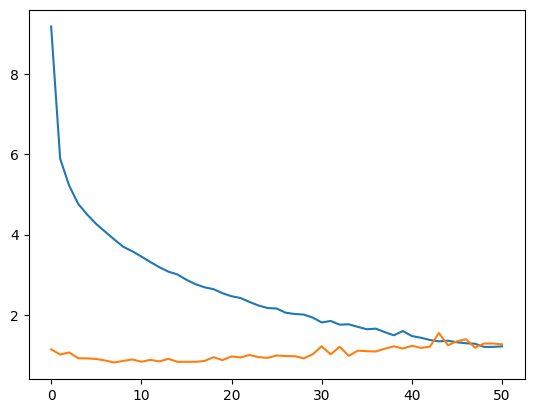

In [ ]:
plt.plot(np.arange(51), T_tr_loss)
plt.plot(np.arange(51), T_vl_loss)
plt.show()

In [8]:
def S_train(S_model, train_loader, valid_loader, epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    S_model = S_model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizr = optim.Adam(S_model.parameters(), lr=0.001)

    S_train_loss = []
    S_val_loss = []
    for epch in tqdm(range(epochs+1)):
        #t_epoch_start = time.time()
        epch_loss = 0.0
        val_epch_loss = 0.0

        # 모델 학습
        S_model.train()
        for batch_idx, (x, target) in enumerate(train_loader):
            x, target = x.to(device), target.to(device)
            target = F.one_hot(target.to(torch.int64), num_classes = 10)

            yhat = S_model(x)

            loss = loss_fn(yhat.float(), target.float())

            optimizr.zero_grad()

            loss.requires_grad_(True)
            loss.backward()

            optimizr.step()

            epch_loss += loss.item()

        # 모델 검증
        S_model.eval()
        with torch.no_grad():
            for batch_idx, (x,y) in enumerate(valid_loader):
                x, y = x.to(device), y.to(device)
                y = F.one_hot(y.to(torch.int64), num_classes = 10)
                val_epch_loss += loss_fn(S_model(x).float(), y.float()).item()

        #모델 결과 확인
        # t_epoch_finish = time.time()
        S_train_loss.append(epch_loss / batch_size)
        S_val_loss.append(val_epch_loss / batch_size)
        # if epch % 10 == 0:
        #     print('Epoch: {}, Loss: {}, Epoch_time: {:.4f}'
        #     .format(epch, epch_loss, t_epoch_finish - t_epoch_start))

    return S_train_loss, S_val_loss

In [22]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

S_model = student_model()
tr_s_loss, vl_s_loss = S_train(S_model, train_loader, valid_loader, epochs = 50)

  0%|          | 0/51 [00:00<?, ?it/s]

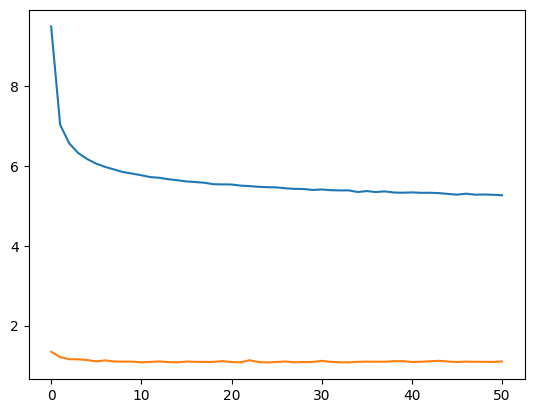

In [23]:
plt.plot(np.arange(51), tr_s_loss)
plt.plot(np.arange(51), vl_s_loss)
plt.show()

### 모델 저장

In [ ]:
torch.save(obj = T_model.state_dict(), f = 'teacher_model_parm.pth')
torch.save(obj = S_model.state_dict(), f = 'student_model_parm.pth')

### 모델 불러오기

In [10]:
new_T_model = teacher_model()
new_T_model.load_state_dict(torch.load('teacher_model_parm.pth'))

<All keys matched successfully>

In [11]:
new_S_model = student_model()
new_S_model.load_state_dict(torch.load('student_model_parm.pth'))

<All keys matched successfully>

## 네트워크 검증

In [ ]:
new_T_model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
new_T_model = new_T_model.to(device)
T_acc = []
for batch_idx, (x,y) in enumerate(valid_loader):
    x, y = x.to(device), y.to(device)
    yhat = new_T_model(x)
    y_pred = np.argmax(yhat.detach().to('cpu'), axis=1)
    T_acc.append((y_pred == y.to('cpu')).sum().item() / len(y))
print("Teacher model acc: {:.4f}".format(sum(T_acc)/len(T_acc)))


Teacher model acc: 0.8862


In [ ]:
new_S_model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
new_S_model = new_S_model.to(device)
T_acc = []
for batch_idx, (x,y) in enumerate(valid_loader):
    x, y = x.to(device), y.to(device)
    yhat = new_S_model(x)
    y_pred = np.argmax(yhat.detach().to('cpu'), axis=1)
    T_acc.append((y_pred == y.to('cpu')).sum().item() / len(y))
print("student model acc without distillation: {:.4f}".format(sum(T_acc)/len(T_acc)))


student model acc without distillation: 0.8424


## Total Loss 정의

In [ ]:
def Total_Loss_fn(student_pred, teacher_pred, alpha, T):
    loss = F.kl_div(F.log_softmax(student_pred / T, dim=1), F.softmax(teacher_pred / T, dim=1), reduction='batchmean') * (T ** 2) * alpha + F.cross_entropy(student_pred, y) * (1 - alpha)
    return loss

### Loss function 작동 실험

In [ ]:
test_model = student_model()
test_model = test_model.to(device)

In [ ]:
y2_pred = test_model(x) # 엉망인 결과

In [ ]:
new_S_model.to(device) # 어느정도 학습된 모델의 결과
y1_pred = new_S_model(x)

In [ ]:
new_T_model.to(device) # target
y_target = new_T_model(x)

In [ ]:
Total_Loss_fn(y2_pred,y_target, T=3,alpha=0.5)

tensor(9.6223, device='cuda:0', grad_fn=<AddBackward0>)

## Knowledge Distillation으로 Student Model 학습

In [12]:
def Distillation_train(T_model, S_model, train_loader, valid_loader, epochs, lr, T, alpha):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    T_model = T_model.to(device)
    S_model = S_model.to(device)

    optimizr = optim.Adam(S_model.parameters(), lr= lr)
    loss_fn = nn.CrossEntropyLoss()
    train_loss = []
    val_loss = []
    for epch in tqdm(range(epochs+1)):
        #t_epoch_start = time.time()
        epch_loss = 0.0
        val_epch_loss = 0.0

        # 모델 학습
        T_model.train()
        S_model.train()
        for batch_idx, (x, target) in enumerate(train_loader):
            x, target = x.to(device), target.to(device)
            target = F.one_hot(target.to(torch.int64), num_classes = 10)

            teacher_pred = T_model(x)
            student_pred = S_model(x)

            loss = F.kl_div(F.log_softmax(student_pred / T, dim=1), F.softmax(teacher_pred / T, dim=1), reduction='batchmean') * (T ** 2) * alpha + F.cross_entropy(student_pred, target.float()) * (1 - alpha)

            optimizr.zero_grad()

            loss.requires_grad_(True)
            loss.backward()

            optimizr.step()

            epch_loss += loss.item()

        # 모델 검증
        S_model.eval()
        with torch.no_grad():
            for batch_idx, (x,y) in enumerate(valid_loader):
                x, y = x.to(device), y.to(device)
                y = F.one_hot(y.to(torch.int64), num_classes = 10)
                val_epch_loss += loss_fn(S_model(x).float(), y.float()).item()

        #모델 결과 확인
        # t_epoch_finish = time.time()
        train_loss.append(epch_loss / batch_size)
        val_loss.append(val_epch_loss / batch_size)
        # if epch % 10 == 0:
        #     print('Epoch: {}, Loss: {}, Epoch_time: {:.4f}'
        #     .format(epch, epch_loss, t_epoch_finish - t_epoch_start))

    return train_loss, val_loss

### 적절한 T 찾기

#### T=2일때의 Distillation

In [16]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

temp1 =[]
temp2 =[]

test_model_2 = student_model()

temp1, temp2 = Distillation_train(T_model=new_T_model, S_model=test_model_2, train_loader= train_loader, valid_loader= valid_loader, epochs = 50, lr = 0.001, T = 2.0, alpha = 0.5)

  0%|          | 0/51 [00:00<?, ?it/s]

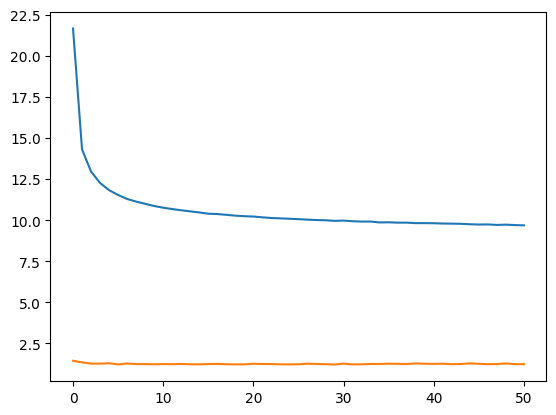

In [17]:
plt.plot(np.arange(51), temp1)
plt.plot(np.arange(51), temp2)
plt.show()

In [18]:
test_model_2.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_model_2 = test_model_2.to(device)
T_acc = []
for batch_idx, (x,y) in enumerate(valid_loader):
    x, y = x.to(device), y.to(device)
    yhat = test_model_2(x)
    y_pred = np.argmax(yhat.detach().to('cpu'), axis=1)
    T_acc.append((y_pred == y.to('cpu')).sum().item() / len(y))
print("student model acc with distillation: {:.4f}".format(sum(T_acc)/len(T_acc)))

student model acc with distillation: 0.8452


#### T = 3일때의 Distillation

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

temp1 =[]
temp2 =[]

test_model_3 = student_model()

temp1, temp2 = Distillation_train(T_model=new_T_model, S_model=test_model_3, train_loader= train_loader, valid_loader= valid_loader, epochs = 50, lr = 0.001, T = 3.0, alpha = 0.5)

  0%|          | 0/51 [00:00<?, ?it/s]

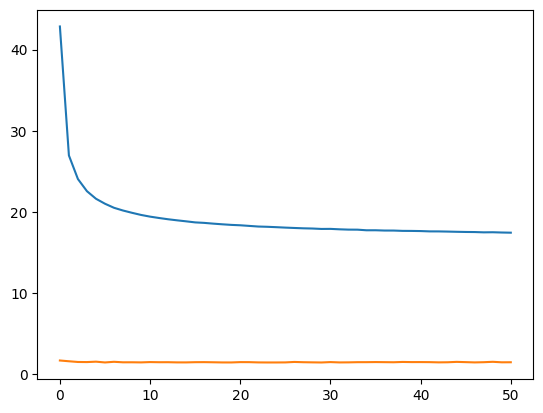

In [ ]:
plt.plot(np.arange(51), temp1)
plt.plot(np.arange(51), temp2)
plt.show()

In [ ]:
test_model_3.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_model_3 = test_model_3.to(device)
T_acc = []
for batch_idx, (x,y) in enumerate(valid_loader):
    x, y = x.to(device), y.to(device)
    yhat = test_model_3(x)
    y_pred = np.argmax(yhat.detach().to('cpu'), axis=1)
    T_acc.append((y_pred == y.to('cpu')).sum().item() / len(y))
print("student model acc with distillation: {:.4f}".format(sum(T_acc)/len(T_acc)))

student model acc with distillation: 0.8384


#### T = 5일때의 Distillation

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

temp1 =[]
temp2 =[]

test_model_5 = student_model()

temp1, temp2 = Distillation_train(T_model=new_T_model, S_model=test_model_5, train_loader= train_loader, valid_loader= valid_loader, epochs = 50, lr = 0.001, T = 5.0, alpha = 0.5)

  0%|          | 0/51 [00:00<?, ?it/s]

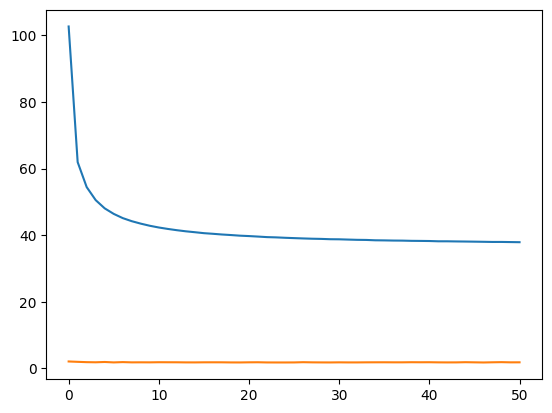

In [ ]:
plt.plot(np.arange(51), temp1)
plt.plot(np.arange(51), temp2)
plt.show()

In [ ]:
test_model_5.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_model_5 = test_model_5.to(device)
T_acc = []
for batch_idx, (x,y) in enumerate(valid_loader):
    x, y = x.to(device), y.to(device)
    yhat = test_model_5(x)
    y_pred = np.argmax(yhat.detach().to('cpu'), axis=1)
    T_acc.append((y_pred == y.to('cpu')).sum().item() / len(y))
print("student model acc with distillation: {:.4f}".format(sum(T_acc)/len(T_acc)))

student model acc with distillation: 0.8243


#### T = 7일때 Distillation

In [13]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

temp1 =[]
temp2 =[]

test_model_7 = student_model()

temp1, temp2 = Distillation_train(T_model=new_T_model, S_model=test_model_7, train_loader= train_loader, valid_loader= valid_loader, epochs = 50, lr = 0.001, T = 7.0, alpha = 0.5)

  0%|          | 0/51 [00:00<?, ?it/s]

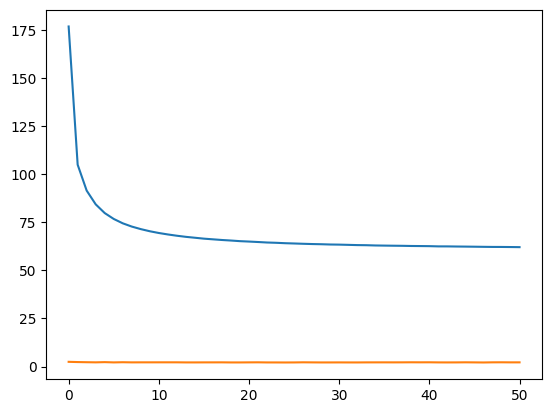

In [14]:
plt.plot(np.arange(51), temp1)
plt.plot(np.arange(51), temp2)
plt.show()

In [15]:
test_model_7.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_model_7 = test_model_7.to(device)
T_acc = []
for batch_idx, (x,y) in enumerate(valid_loader):
    x, y = x.to(device), y.to(device)
    yhat = test_model_7(x)
    y_pred = np.argmax(yhat.detach().to('cpu'), axis=1)
    T_acc.append((y_pred == y.to('cpu')).sum().item() / len(y))
print("student model acc with distillation: {:.4f}".format(sum(T_acc)/len(T_acc)))

student model acc with distillation: 0.8129


- Temperture 바꾸기 (*Distillation 없이 학습 진행하면 정확도는 84.24%*)

|T value|acc|$\alpha$|
|:---:|:---:|:---:|
|2|84.52|0.5|
|3|83.84|0.5|
|5|82.43|0.5|
|7|81.29|0.5|

### 적절한 $\alpha$ 찾기

#### $\alpha = 0.1$일때의 Distillation

  0%|          | 0/51 [00:00<?, ?it/s]

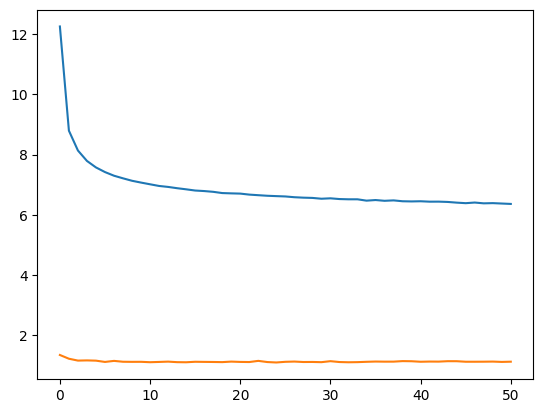

student model acc with distillation: 0.8455


In [19]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

temp1 =[]
temp2 =[]

test_model_01 = student_model()

temp1, temp2 = Distillation_train(T_model=new_T_model, S_model=test_model_01, train_loader= train_loader, valid_loader= valid_loader, epochs = 50, lr = 0.001, T = 2.0, alpha = 0.1)

plt.plot(np.arange(51), temp1)
plt.plot(np.arange(51), temp2)
plt.show()

test_model_01.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_model_01 = test_model_01.to(device)
T_acc = []
for batch_idx, (x,y) in enumerate(valid_loader):
    x, y = x.to(device), y.to(device)
    yhat = test_model_01(x)
    y_pred = np.argmax(yhat.detach().to('cpu'), axis=1)
    T_acc.append((y_pred == y.to('cpu')).sum().item() / len(y))
print("student model acc with distillation: {:.4f}".format(sum(T_acc)/len(T_acc)))

#### $\alpha = 0.3$일때의 Distillation

  0%|          | 0/51 [00:00<?, ?it/s]

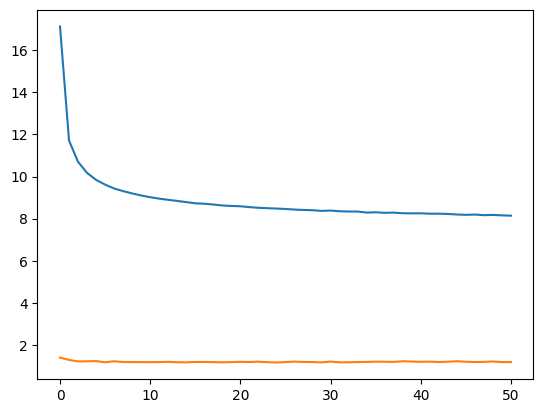

student model acc with distillation: 0.8469


In [20]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

temp1 =[]
temp2 =[]

test_model_03 = student_model()

temp1, temp2 = Distillation_train(T_model=new_T_model, S_model=test_model_03, train_loader= train_loader, valid_loader= valid_loader, epochs = 50, lr = 0.001, T = 2.0, alpha = 0.3)

plt.plot(np.arange(51), temp1)
plt.plot(np.arange(51), temp2)
plt.show()

test_model_03.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_model_03 = test_model_03.to(device)
T_acc = []
for batch_idx, (x,y) in enumerate(valid_loader):
    x, y = x.to(device), y.to(device)
    yhat = test_model_03(x)
    y_pred = np.argmax(yhat.detach().to('cpu'), axis=1)
    T_acc.append((y_pred == y.to('cpu')).sum().item() / len(y))
print("student model acc with distillation: {:.4f}".format(sum(T_acc)/len(T_acc)))

#### $\alpha = 0.7$일때의 Distillation

  0%|          | 0/51 [00:00<?, ?it/s]

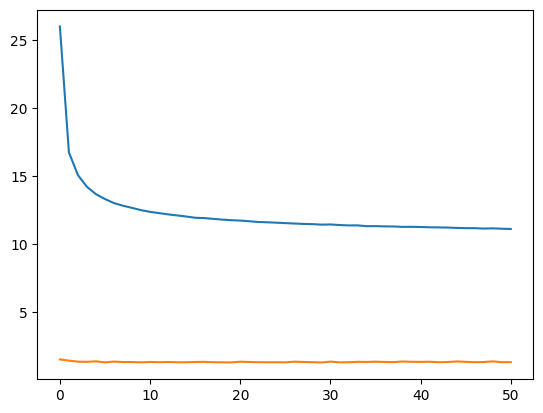

student model acc with distillation: 0.8426


In [21]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

temp1 =[]
temp2 =[]

test_model_07 = student_model()

temp1, temp2 = Distillation_train(T_model=new_T_model, S_model=test_model_07, train_loader= train_loader, valid_loader= valid_loader, epochs = 50, lr = 0.001, T = 2.0, alpha = 0.7)

plt.plot(np.arange(51), temp1)
plt.plot(np.arange(51), temp2)
plt.show()

test_model_07.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_model_07 = test_model_07.to(device)
T_acc = []
for batch_idx, (x,y) in enumerate(valid_loader):
    x, y = x.to(device), y.to(device)
    yhat = test_model_07(x)
    y_pred = np.argmax(yhat.detach().to('cpu'), axis=1)
    T_acc.append((y_pred == y.to('cpu')).sum().item() / len(y))
print("student model acc with distillation: {:.4f}".format(sum(T_acc)/len(T_acc)))

- $\alpha$ 바꾸기  (*Distillation 없이 학습 진행하면 정확도는 84.24%*)

|T value|acc|$\alpha$|
|:---:|:---:|:---:|
|2|84.55|0.1|
|2|84.69|0.3|
|2|84.52|0.5|
|2|84.26|0.7|

`▶` T = 2, α = 0.3 일 때 Response-based Knowledge는 최적의 성능을 보임  
*Distillation을 하지 않은 Student Model보다 0.5% 높은 정확도를 보임*